In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import json
import warnings

### Metrics to look at:
* Metrics over time
* Comparison of Hyperparameters
* Metrics at the beginning of training:
    * Why does scaling embeddings screw things up so much? Even when it's just the initialization --> must be an issue at the beginning of training, could be something interesting to look into

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', 999)

In [3]:
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [4]:
model_path = '../models/'

In [13]:
config_list = []
test_metric_list = []
oos_metric_list = []
loss_hist_list = []
test_factor_df_list = []


def find_metrics_in_dir(base_path):
    for f in os.listdir(base_path):
        if f in ['300s', '.gitignore', 'addition_baselines', 'addition_small_as_possible']: continue
        print(f)
        subdir_path = base_path + f + '/'
        
        if os.path.exists(subdir_path + 'checkpoints/'):
            config_path = subdir_path + 'config.yaml'
            metrics_path = subdir_path + 'metrics_test.json'
            metrics_oos_path = subdir_path + 'metrics_oos.json'
            loss_hist_path = subdir_path + 'loss_hist.csv'
            
            if not os.path.exists(metrics_path):
                continue

            config_list.append(load_yaml(config_path))
            test_metric_list.append(load_json(metrics_path))
            oos_metric_list.append(load_json(metrics_oos_path))
            loss_hist_list.append(pd.read_csv(loss_hist_path))
            
            test_factor_df_list.append(pd.read_csv(subdir_path + 'factor_df_test.csv'))
            
        elif os.path.isdir(subdir_path) and not f=='checkpoints':
            find_metrics_in_dir(subdir_path)

In [14]:
find_metrics_in_dir(model_path)

HPARAM_search
baseline_10_enc_dec_layers
baseline_12_enc_dec_layers
baseline_16_enc_dec_layers
baseline_24_enc_dec_layers
baseline_2_enc_dec_layers
baseline_4_enc_dec_layers
baseline_8_enc_dec_layers
baseline_base30
baseline_base30_high_attn_init
baseline_base30_no_relative_pe
baseline_base30_repeat_pe
baseline_base30_repeat_pe_qk_only
baseline_base7
baseline_base8
baseline_base_210
baseline_base_237
baseline_base_7_rerun
baseline_base_90
baseline_embed_dim_256
baseline_embed_dim_512
baseline_embed_dim_64
baseline_higher_dropout
baseline_min_lr_scale
baseline_norm_first
baseline_no_extra_attn
baseline_no_shared_embeddings
baseline_scale_embeddings
baseline_weight_decay
baseline_weight_decay_larger
baseline_weight_decay_larger_2
baseline_weight_decay_larger_3
baseline_xavier_init
baseline_xavier_init_scale_embeddings
baseline_xavier_init_scale_embeddings_init
basline_batch_128
basline_batch_256
basline_batch_512
basline_batch_512_3200_epoch
basline_batch_512_6400_epoch
basline_batch_512

In [15]:
len(config_list), len(test_metric_list), len(oos_metric_list), len(loss_hist_list), len(test_factor_df_list)

(38, 38, 38, 38, 38)

In [16]:
def flatten_config(config_item):
    expanded = {}
    expanded['base'] = config_item['data']['base']
    expanded['train_data'] = config_item['data']['train_path']
    expanded['train_batch_size'] = config_item['loader']['train']['batch_size']
    for k, v in config_item['model_args'].items():
        expanded[k] = v
    if not 'embedding_initialization' in expanded:
        expanded['embedding_initialization'] = 'normal'
    expanded['optimizer'] = config_item['optimizer']['type']
    for k, v in config_item['optimizer']['opt_args'].items():
        expanded[k] = v
    if not 'weight_decay' in expanded:
        expanded['weight_decay'] = 0
    expanded['gradient_accumulation_steps'] = config_item['optimizer']['gradient_accumulation_steps']
#     handle all model args
#     handle all opt args
    try:
        expanded['num_warmup_steps'] = config_item['scheduler']['n_warmup_steps']
    except KeyError:
        expanded['num_warmup_steps'] = config_item['scheduler']['scheduler_args']['num_warmup_steps']
    expanded['nb_epochs'] = config_item['scheduler']['nb_epochs']
    expanded['max_grad_norm'] = config_item['optimizer']['max_grad_norm']
    
    expanded['effective_train_batch_size'] = expanded['train_batch_size'] * expanded['gradient_accumulation_steps']
    del expanded['train_batch_size']
    del expanded['gradient_accumulation_steps']
    
    
    return expanded

In [17]:
configs = [flatten_config(c) for c in config_list]
config_df = pd.DataFrame.from_dict(configs)

In [18]:
config_df

,base,train_data,attn_weight_xavier_init_constant,dim_feedforward,dropout,embed_dim,embedding_initialization,extra_positional_encoding_relative_decoder_mha,learn_positional_encoding,max_decode_size,...,scale_embeddings,scale_embeddings_at_init,shared_embeddings,optimizer,lr,weight_decay,num_warmup_steps,nb_epochs,max_grad_norm,effective_train_batch_size
0,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,AdamW,0.001,0.10,6000,200,1,256
1,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,AdamW,0.001,0.10,6000,200,1,256
2,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,AdamW,0.001,0.10,6000,200,1,256
3,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,AdamW,0.001,0.10,6000,200,1,256
4,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,AdamW,0.001,0.10,6000,200,1,256
5,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,AdamW,0.001,0.10,6000,200,1,256
6,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,adam,0.001,0.00,24000,200,1,64
7,30,data/train_data_2^16.npy,1.0,512,0.05,128,normal,True,False,64,...,False,False,True,adam,0.001,0.00,24000,200,1,64
8,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,adam,0.001,0.00,24000,200,1,64
9,30,data/train_data_2^16.npy,0.5,512,0.05,128,normal,True,False,64,...,False,False,True,adam,0.001,0.00,24000,200,1,64


In [19]:
def get_nice_metrics(metric_list, suffix = ''):
    correct = pd.DataFrame.from_dict([l['correct'] for l in metric_list])
    n_beams = pd.DataFrame.from_dict([l['meta']['n_beams'] for l in metric_list])
    
    def get_loss(metric_dict):
        try:
            return metric_dict['loss']
        except KeyError:
            return metric_dict['test_loss']
        
    loss_df = pd.DataFrame.from_dict([get_loss(l) for l in metric_list])
    
    n_beams.columns = ['n_beams']
    loss_df.columns = ['loss']
    to_return = [correct, n_beams, loss_df]
    if suffix:
        for tmp_df in to_return:
            tmp_df.columns = [str(c) + f'_{suffix}' for c in tmp_df.columns]
    return to_return

In [20]:
merged = pd.concat([config_df] + get_nice_metrics(test_metric_list, 'test') + get_nice_metrics(oos_metric_list, 'oos'), axis=1)

In [21]:
assert (merged['n_beams_test']==merged['n_beams_oos']).all()
merged['n_beams'] = merged['n_beams_oos']
merged.drop(['n_beams_test', 'n_beams_oos'], axis=1, inplace=True)

In [22]:
# Drop all confiuraiton columns that have no variantion b/c that's not super helpful
drop_cols = []
for c in list(config_df) + ['n_beams']:
    if not c in merged: continue
    if merged[c].nunique()==1:
        drop_cols.append(c)
metric_df = merged.drop(drop_cols, axis=1)

In [23]:
metric_df

,base,train_data,attn_weight_xavier_init_constant,dropout,embed_dim,embedding_initialization,extra_positional_encoding_relative_decoder_mha,norm_first,num_decoder_layers,num_encoder_layers,...,weight_decay,num_warmup_steps,nb_epochs,effective_train_batch_size,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,10,10,...,0.10,6000,200,256,0.979356,0.861415,0.047529,0.933594,0.694824,0.119473
1,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,12,12,...,0.10,6000,200,256,0.974954,0.857468,0.048018,0.912598,0.677246,0.124622
2,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,16,16,...,0.10,6000,200,256,0.974803,0.857013,0.048752,0.757812,0.595703,0.158729
3,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,2,2,...,0.10,6000,200,256,0.945507,0.561779,0.110729,0.806152,0.370117,0.174067
4,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,4,4,...,0.10,6000,200,256,0.962356,0.796752,0.057410,0.770020,0.521973,0.151557
5,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,8,8,...,0.10,6000,200,256,0.979053,0.860049,0.047189,0.943848,0.691406,0.123346
6,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.959168,0.727838,0.070385,0.896973,0.516113,0.166403
7,30,data/train_data_2^16.npy,1.0,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.934730,0.658470,0.088125,0.859375,0.448242,0.166683
8,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.949909,0.659836,0.086440,0.812500,0.414062,0.185352
9,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.948543,0.696418,0.079208,0.896484,0.498535,0.144379


In [24]:
metrics = ['correct_product', 'correct_factorization', 'loss']
splits = ['test', 'oos']
metrics_full = [f'{metric}_{split}' for split in splits for metric in metrics]

In [25]:
metrics_full

['correct_product_test',
 'correct_factorization_test',
 'loss_test',
 'correct_product_oos',
 'correct_factorization_oos',
 'loss_oos']

In [26]:
metric_df

,base,train_data,attn_weight_xavier_init_constant,dropout,embed_dim,embedding_initialization,extra_positional_encoding_relative_decoder_mha,norm_first,num_decoder_layers,num_encoder_layers,...,weight_decay,num_warmup_steps,nb_epochs,effective_train_batch_size,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,10,10,...,0.10,6000,200,256,0.979356,0.861415,0.047529,0.933594,0.694824,0.119473
1,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,12,12,...,0.10,6000,200,256,0.974954,0.857468,0.048018,0.912598,0.677246,0.124622
2,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,16,16,...,0.10,6000,200,256,0.974803,0.857013,0.048752,0.757812,0.595703,0.158729
3,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,2,2,...,0.10,6000,200,256,0.945507,0.561779,0.110729,0.806152,0.370117,0.174067
4,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,4,4,...,0.10,6000,200,256,0.962356,0.796752,0.057410,0.770020,0.521973,0.151557
5,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,8,8,...,0.10,6000,200,256,0.979053,0.860049,0.047189,0.943848,0.691406,0.123346
6,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.959168,0.727838,0.070385,0.896973,0.516113,0.166403
7,30,data/train_data_2^16.npy,1.0,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.934730,0.658470,0.088125,0.859375,0.448242,0.166683
8,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.949909,0.659836,0.086440,0.812500,0.414062,0.185352
9,30,data/train_data_2^16.npy,0.5,0.05,128,normal,True,False,6,6,...,0.00,24000,200,64,0.948543,0.696418,0.079208,0.896484,0.498535,0.144379


In [27]:
def make_correlation_plot(metric_df, x, y):
    metric_df.plot.scatter(x=x, y=y)
    
    x_col = metric_df[x]
    y_col = metric_df[y]
    
    m, b = np.polyfit(x_col, y_col, 1)
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    plt.plot(x_vals, m*x_vals + b, color='black', linestyle='--', alpha=.5)
    plt.title(f'Correlation between {x} and {y}')
    plt.show()

### Look at some correlations
#### In general:
* Correlation using correct_product is not very strong in many places.
    * I think this makes sense because of the issue where when the model is unable to factor the number, it returns the number because it could be prime

#### Test metrics vs OoS Metrics:
* Test loss is very correlated with Oos. Same for factorization, but not quite as much

#### Is loss correlated of correct factorizatoin?
* Yes! Loss is very correlated with correct factorization

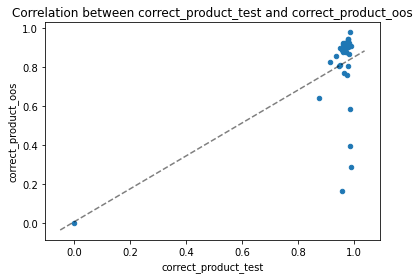

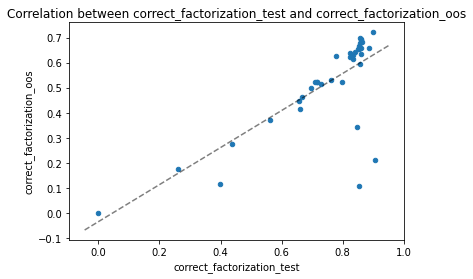

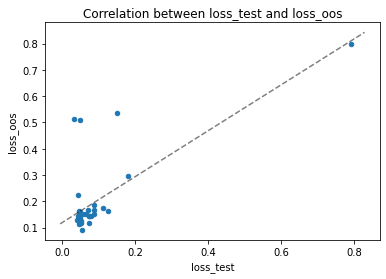

In [28]:
for m in metrics:
    make_correlation_plot(metric_df, x=m + f'_{splits[0]}', y=m + f'_{splits[1]}')

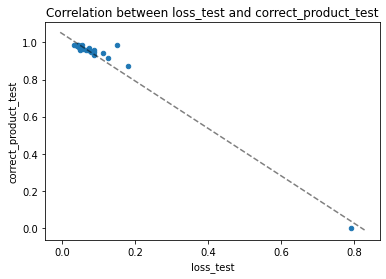

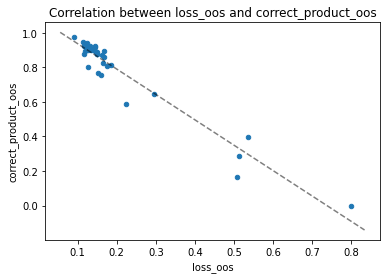

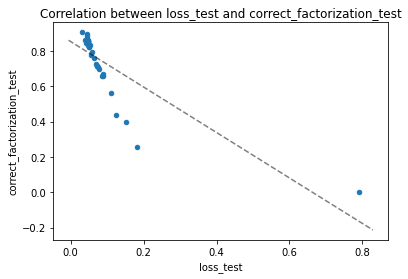

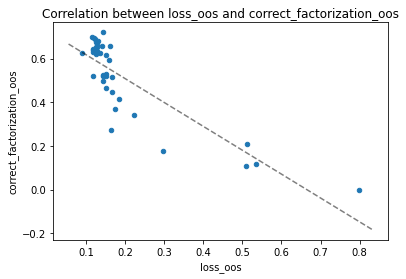

In [29]:
for m in metrics:
    if m == 'loss' : continue
    for s in splits:
        make_correlation_plot(metric_df, x=f'loss_{s}', y = f'{m}_{s}')

In [30]:
hyperparam_cols = [c for c in metric_df.columns if not c in metrics_full]

In [31]:
hyperparam_cols

['base',
 'train_data',
 'attn_weight_xavier_init_constant',
 'dropout',
 'embed_dim',
 'embedding_initialization',
 'extra_positional_encoding_relative_decoder_mha',
 'norm_first',
 'num_decoder_layers',
 'num_encoder_layers',
 'positional_encoding_query_key_only',
 'relative_positional_encoding',
 'repeat_positional_encoding',
 'scale_embeddings',
 'scale_embeddings_at_init',
 'shared_embeddings',
 'optimizer',
 'weight_decay',
 'num_warmup_steps',
 'nb_epochs',
 'effective_train_batch_size']

In [32]:
metrics_lower_is_better = {'loss'}

def style_col_axis_1(col, n_highlight=3, col_id_name="id"):
#     if col.name==col_id_name:
#         return [f'background-color: {col[i]}' for i in range(len(col))]
    if len(set(col.name.split('_')).intersection(metrics_lower_is_better)):
        top_indicies = np.argsort(col.values)[:n_highlight]
    else:
        top_indicies = np.argsort(col.values)[::-1][:n_highlight]
    alphas = np.zeros(len(col))
    for i in range(len(top_indicies)):
        alphas[top_indicies[i]] = 1 - i/n_highlight
    return np.array([f'background-color: rgba(0,169,0,{alphas[i]})' for i in range(len(col))])

def style_df(df, ablated_hparams = None, n_highlight=3, col_id_name="color"):
    if ablated_hparams is None:
        ablated_hparams = []
    to_return = np.zeros_like(df.values, dtype=np.object)
    df_cols = df.columns
#     display(df)
    for i in range(df.shape[1]):
        this_col = df_cols[i]
        if this_col in ablated_hparams: continue
        if this_col in hyperparam_cols:
            to_return[:,i] = np.array([f'background-color: {df[col_id_name].iloc[j]}' for j in range(df.shape[0])])
#             print(to_return)
        else:
            to_return[:,i] = style_col_axis_1(df.iloc[:,i], n_highlight, col_id_name)
    return to_return

In [33]:
metric_df.sort_values(hyperparam_cols).style.apply(style_col_axis_1, axis=0, subset=metrics_full)

,base,train_data,attn_weight_xavier_init_constant,dropout,embed_dim,embedding_initialization,extra_positional_encoding_relative_decoder_mha,norm_first,num_decoder_layers,num_encoder_layers,positional_encoding_query_key_only,relative_positional_encoding,repeat_positional_encoding,scale_embeddings,scale_embeddings_at_init,shared_embeddings,optimizer,weight_decay,num_warmup_steps,nb_epochs,effective_train_batch_size,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
15,7,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,6,6,False,True,False,False,False,True,AdamW,0.100000,24000,200,64,0.913783,0.438373,0.124756,0.827637,0.275391,0.163973
11,7,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,6,6,False,True,True,False,False,True,adam,0.000000,24000,200,64,0.874772,0.259259,0.181037,0.643555,0.177734,0.296095
12,8,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,6,6,False,True,True,False,False,True,adam,0.000000,24000,200,64,0.985580,0.398452,0.150913,0.394531,0.116699,0.535876
19,30,data/train_data_2^16.npy,0.500000,0.050000,64,normal,True,False,6,6,False,True,False,False,False,True,AdamW,0.100000,6000,200,256,0.957650,0.668033,0.087711,0.887695,0.463867,0.150055
22,30,data/train_data_2^16.npy,0.500000,0.050000,128,normal,False,False,6,6,False,True,False,False,False,True,AdamW,0.100000,10000,200,64,0.967517,0.835003,0.048632,0.895508,0.631348,0.118688
3,30,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,2,2,False,True,False,False,False,True,AdamW,0.100000,6000,200,256,0.945507,0.561779,0.110729,0.806152,0.370117,0.174067
4,30,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,4,4,False,True,False,False,False,True,AdamW,0.100000,6000,200,256,0.962356,0.796752,0.057410,0.770020,0.521973,0.151557
8,30,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,6,6,False,False,False,False,False,True,adam,0.000000,24000,200,64,0.949909,0.659836,0.086440,0.812500,0.414062,0.185352
9,30,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,6,6,False,False,True,False,False,True,adam,0.000000,24000,200,64,0.948543,0.696418,0.079208,0.896484,0.498535,0.144379
23,30,data/train_data_2^16.npy,0.500000,0.050000,128,normal,True,False,6,6,False,True,False,False,False,False,AdamW,0.100000,6000,200,256,0.980115,0.862174,0.045891,0.925293,0.682617,0.131770


# Rework this:
* There should be a function that subset the dataframe to the rows we care about
* That function should get used in abalte hyperparamater + ablate loss hist plot
* Right now there are two functiuons and they kinda work differently... they should just be the same

In [34]:
def add_identifier_for_hparam_sets(df, hparam_cols, values, col_name='color'): 
    df['groupby_hps'] = df[hparam_cols].apply(lambda x: '_'.join([str(y) for y in x]), axis=1)
#     df.sort_values('groupby_hps', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df[col_name] = values[0]
    value_counter = 0
    for i in range(1, df.shape[0]):
        this_row_hps = df.iloc[i]['groupby_hps']
        prev_row_hps = df.iloc[i-1]['groupby_hps']
        if not this_row_hps==prev_row_hps:
            value_counter +=1
        df.loc[i, col_name] = values[value_counter%len(values)]
        if value_counter>=len(values):
            warnings.warn(f'More unique combinations of hyperparams found than unique {col_name}; {col_name} will not be unique')
    df.drop('groupby_hps', axis=1, inplace=True)
    return df


In [35]:
colors = ['rgba(255,0,0,.5)', 'rgba(48,213,200,.5)', 'rgba(159,43,104,.5)', 'rgba(230,190,138,.5)']

def ablate_hyperparameter(metric_df, hparams, show_specific_hparams=None, show_all_other_hparams=False, show_if_nonconstant=True):
    id_col_name = 'color'
    if isinstance(hparams, str):
        hparams = [hparams]
    hparams = hparams
    groupby_hps = [c for c in hyperparam_cols if not c in hparams]
    grouped = metric_df.groupby(groupby_hps)
    grouped = grouped.filter(lambda x: len(x) > 1)
    grouped = add_identifier_for_hparam_sets(grouped, groupby_hps, colors, id_col_name)

    
    # Have a list of params want to show
    # Want to show just ones that have unique values
    # Show all of them
    
    if show_specific_hparams:
          if isinstance(show_specific_hparams, str):
            show_specific_hparams = [show_specific_hparams]
    else:
        show_specific_hparams = []
    
    show_cols = [c for c in grouped.columns if not (c in groupby_hps) or c==id_col_name]
    for c in groupby_hps:
        if (show_all_other_hparams) or (show_specific_hparams in show_specific_hparams) or (show_if_nonconstant and grouped[c].nunique() > 1):
            show_cols.append(c)
            
    grouped = grouped[[c for c in show_cols]]
    grouped.sort_values(hparams, inplace=True)

    
#     hide_params = [id_col_name]
#     for c in grouped.columns:
#         if (not show_all_other_hparams) or (not c in show_specific_hparams) or \
#            (hide_just_constant_hparams and grouped[c].nunique() == 1):
#             hide_params.append(c)
            
#     grouped = grouped[c for c in grouped.columns if not c in hide_params]
    
    
#     if show_specific_hparams:
#         if isinstance(show_specific_hparams, str):
#             show_specific_hparams = [show_specific_hparams]
#         grouped = grouped[[c for c in metric_df.columns if (not c in groupby_hps) or (c in show_specific_hparams) or (c=='color')]]
#     elif not show_all_other_hparams:
#         grouped = grouped[[c for c in grouped.columns if (not c in groupby_hps) or c==id_col_name]]
        
    return grouped.style.hide_columns([id_col_name]).apply(style_df, axis=None, ablated_hparams = hparams, n_highlight=1)
#     return grouped.style.apply(style_col, axis=0, subset=metrics_full + [id_col_name], n_highlight=1)

In [36]:
ablate_hyperparameter(metric_df, 'scale_embeddings')

<ipython-input-32-b9323a2d0d65>:18: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_return = np.zeros_like(df.values, dtype=np.object)


,scale_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos,embedding_initialization,optimizer,weight_decay,num_warmup_steps,effective_train_batch_size
0,False,0.959168,0.727838,0.070385,0.896973,0.516113,0.166403,normal,adam,0.000000,24000,64
2,False,0.978901,0.855798,0.046261,0.945801,0.697754,0.114236,xavier,AdamW,0.100000,6000,256
1,True,0.960231,0.716910,0.073398,0.922363,0.522461,0.144273,normal,adam,0.000000,24000,64
3,True,0.969186,0.850789,0.048823,0.905273,0.655273,0.128929,xavier,AdamW,0.100000,6000,256


In [37]:
ablate_hyperparameter(metric_df, ['weight_decay', 'optimizer'])

<ipython-input-32-b9323a2d0d65>:18: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_return = np.zeros_like(df.values, dtype=np.object)


,optimizer,weight_decay,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,adam,0.000000,0.959168,0.727838,0.070385,0.896973,0.516113,0.166403
1,AdamW,0.010000,0.959927,0.761081,0.063798,0.880859,0.530273,0.150084
2,AdamW,0.050000,0.964784,0.826351,0.049212,0.900879,0.627930,0.134887
3,AdamW,0.100000,0.971160,0.824833,0.050255,0.909180,0.623535,0.125664
4,AdamW,0.250000,0.968579,0.709624,0.073895,0.923828,0.521973,0.118576


In [31]:
ablate_hyperparameter(metric_df, ['effective_train_batch_size', 'num_warmup_steps'])

,num_warmup_steps,effective_train_batch_size,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,24000,64,0.971160,0.824833,0.050255,0.909180,0.623535,0.125664
1,12000,128,0.970097,0.840164,0.047680,0.879883,0.642578,0.117346
2,6000,256,0.978142,0.854736,0.045719,0.920898,0.666016,0.128519
3,3000,512,0.969945,0.833789,0.052237,0.878418,0.616211,0.150475


In [32]:
ablate_hyperparameter(metric_df, ['nb_epochs', 'num_warmup_steps'])

,num_warmup_steps,nb_epochs,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,3000,200,0.969945,0.833789,0.052237,0.878418,0.616211,0.150475
2,12000,800,0.976624,0.859745,0.044800,0.901855,0.656738,0.140578
1,24000,3200,0.987705,0.899666,0.044012,0.907715,0.720703,0.143123


In [33]:
ablate_hyperparameter(metric_df, ['embedding_initialization', 'scale_embeddings', 'scale_embeddings_at_init'])

,embedding_initialization,scale_embeddings,scale_embeddings_at_init,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos,optimizer,weight_decay,num_warmup_steps,effective_train_batch_size
0,normal,False,False,0.959168,0.727838,0.070385,0.896973,0.516113,0.166403,adam,0.000000,24000,64
5,normal,False,False,0.978142,0.854736,0.045719,0.920898,0.666016,0.128519,AdamW,0.100000,6000,256
1,normal,True,False,0.960231,0.716910,0.073398,0.922363,0.522461,0.144273,adam,0.000000,24000,64
2,xavier,False,False,0.978901,0.855798,0.046261,0.945801,0.697754,0.114236,AdamW,0.100000,6000,256
3,xavier,True,False,0.969186,0.850789,0.048823,0.905273,0.655273,0.128929,AdamW,0.100000,6000,256
4,xavier,True,True,0.976776,0.852307,0.046058,0.903320,0.653320,0.126217,AdamW,0.100000,6000,256


In [34]:
ablate_hyperparameter(metric_df, ['dropout'])

,dropout,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
1,0.050000,0.978142,0.854736,0.045719,0.920898,0.666016,0.128519
0,0.100000,0.966910,0.822860,0.051705,0.922852,0.640137,0.117378


In [35]:
ablate_hyperparameter(metric_df, ['shared_embeddings'], show_specific_hparams = ['dropout'])

,shared_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,False,0.980115,0.862174,0.045891,0.925293,0.682617,0.131770
1,True,0.978142,0.854736,0.045719,0.920898,0.666016,0.128519


In [34]:
ablate_hyperparameter(metric_df, ['shared_embeddings'], show_specific_hparams = ['dropout'])

,shared_embeddings,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
0,False,0.980115,0.862174,0.045891,0.925293,0.682617,0.131770
1,True,0.978142,0.854736,0.045719,0.920898,0.666016,0.128519


In [35]:
ablate_hyperparameter(metric_df, ['num_encoder_layers', 'num_decoder_layers'])

,num_decoder_layers,num_encoder_layers,correct_product_test,correct_factorization_test,loss_test,correct_product_oos,correct_factorization_oos,loss_oos
3,2,2,0.945507,0.561779,0.110729,0.806152,0.370117,0.174067
4,4,4,0.962356,0.796752,0.057410,0.770020,0.521973,0.151557
6,6,6,0.978142,0.854736,0.045719,0.920898,0.666016,0.128519
5,8,8,0.979053,0.860049,0.047189,0.943848,0.691406,0.123346
0,10,10,0.979356,0.861415,0.047529,0.933594,0.694824,0.119473
1,12,12,0.974954,0.857468,0.048018,0.912598,0.677246,0.124622
2,16,16,0.974803,0.857013,0.048752,0.757812,0.595703,0.158729


In [38]:
sys.exit()

NameError: name 'sys' is not defined

In [ ]:
# values = metric_df[metric_df['dropout']==.1][hyperparam_cols].to_dict(orient='index')[14]
# del values['base']
# del values['norm_first']
# del values['effective_train_batch_size']
# del values['attn_weight_xavier_init_constant']
# del values['dropout']
# del values['extra_positional_encoding_relative_decoder_mha']
# del values['positional_encoding_query_key_only']
# del values['repeat_positional_encoding']

In [ ]:
def drop_nonunique_hparams(df):
    for c in hyperparam_cols:
        if not c in df:
            continue
        if df[c].nunique()==1:
            df.drop(c, axis=1, inplace=True)
    return df

In [ ]:
# def add_identifier_for_hparam_sets(df, hparam_cols, values, col_name='id'):
#     df['groupby_hps'] = df[hparam_cols].apply(lambda x: '_'.join(str(x)), axis=1)
#     df.sort('groupby_hps')
    
#     df[col_name] = values[0]
#     marker_counter = 0
#     for i in range(1, grouped.shape[0]):
#         this_row_hps = grouped.iloc[i]['groupby_hps'].to_dict()
#         prev_row_hps = grouped.iloc[i-1]['groupby_hps'].to_dict()
#         if not this_row_hps==prev_row_hps:
#             marker_counter +=1
#         grouped.loc[i, col_name] = valid_markers[marker_counter%len(values)]
#         if marker_counter>=len(values):
#             warnings.warn(f'More unique combinations of hyperparams found than unique {col_name}; {col_name} will not be unique')
#     return df
    
    
    

In [ ]:
valid_markers = ['o', 's', '*', 'p', 'D']
def ablate_loss_hist_plot(metric_df, hparams, plot_metric = 'test_loss'):
#     def add_marker()
    if isinstance(hparams, str):
        hparams = [hparams]
    groupby_hps = [c for c in hyperparam_cols if not c in hparams]
    grouped = metric_df.groupby(groupby_hps)
    grouped = grouped.filter(lambda x: len(x) > 1).reset_index(drop=True)
    display(grouped)
    grouped = add_identifier_for_hparam_sets(grouped, groupby_hps, valid_markers, col_name='marker')
    display(grouped)
    
#     grouped['marker'] = valid_markers[0]
#     marker_counter = 0
#     for i in range(1, grouped.shape[0]):
#         this_row_hps = grouped.iloc[i][groupby_hps].to_dict()
#         prev_row_hps = grouped.iloc[i-1][groupby_hps].to_dict()
#         if not this_row_hps==prev_row_hps:
#             marker_counter +=1
#         grouped.loc[i, 'marker'] = valid_markers[marker_counter%len(valid_markers)]
    
    grouped = drop_nonunique_hparams(grouped)
    grouped.reset_index(drop=True, inplace=True)
    remaining_hparams = [c for c in list(grouped) if c in hyperparam_cols]
    
    
    
    grouped['mpl_label'] = grouped[remaining_hparams].apply(lambda x: ', '.join([f"{c}: {x[c]}" for c in remaining_hparams]),axis=1)

    
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    marker_idx = 0
    for i in range(grouped.shape[0]):
        row = grouped.iloc[i]
        loss_hist_list[i].plot(x='step', y=plot_metric, label = row['mpl_label'], ax=ax, marker=row['marker'])

    
    plt.ylabel(plot_metric)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
    plt.show()

# This plot looks wrong to me!!!

In [ ]:
ablate_loss_hist_plot(metric_df, 'base', 'oos_loss')

In [ ]:
ablate_loss_hist_plot(metric_df, ['weight_decay', 'optimizer'], 'oos_loss')

In [ ]:
ablate_loss_hist_plot(metric_df, ['effective_train_batch_size', 'num_warmup_steps'], 'oos_loss')

In [ ]:
ablate_loss_hist_plot(metric_df, ['dropout'], 'oos_loss')

### What are some hard numbers?

In [ ]:
for i in range(len(test_factor_df_list)):
    test_factor_df_list[i]['id'] = i

In [ ]:
all_factor_dfs = pd.concat(test_factor_df_list)

In [ ]:
def get_top_n_factor_dfs(n, metric = 'loss_oos', descending=False):
    ordering = np.argsort(metric_df[metric]).values
    if descending:
        ordering = ordering[::-1]
        
    top_indicies = set(list(ordering[:n]))
    
    all_factor_dfs['keep'] = all_factor_dfs.apply(lambda x: x['id'] in top_indicies, axis=1)
    subs_df = all_factor_dfs[all_factor_dfs['keep']].copy()
    
    all_factor_dfs.drop('keep', axis=1, inplace=True)
    subs_df.drop('keep', axis=1, inplace=True)
    
    return subs_df
    
    

In [ ]:
get_top_n_factor_dfs(3, 'correct_factorization_oos', descending=True)

In [ ]:
num_times_correctly_factored = all_factor_dfs.groupby(['input_num', 'id']).agg({'correct_factorization' : 'any'}).groupby(['input_num']).agg({'correct_factorization' : 'sum'})

In [ ]:
num_times_correctly_factored['correct_factorization'].hist(bins=16)

In [ ]:
num_times_correctly_factored[num_times_correctly_factored['correct_factorization']==0]

In [ ]:
num_times_correctly_factored[num_times_correctly_factored['correct_factorization']==0].reset_index()['input_num'].apply(lambda x: x % 2).value_counts()